In [ ]:
# Experiment 3 KD with a much smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

ModuleNotFoundError: No module named 'Distiller'

In [ ]:
# Set up dataset
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train.shape

In [5]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=3, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPool2D(strides=2))
    model.add(layers.Conv2D(filters=3, kernel_size=(5,5), activation='relu'))
    model.add(layers.MaxPool2D(strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))    
    
    return model

In [6]:
# Construct/load models

teacher_model = tf.keras.models.load_model('LeNetTeacherModel')
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

# Perform the stratified 10 fold cross validation
number_of_folds = 10

skf = StratifiedKFold(n_splits=number_of_folds)

In [7]:
# Haperparameter used in the experiment
number_of_epochs = 10

train_results_with_distillation = []
train_results_without_distillation = []

val_results_with_distillation = []
val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1,
        temperature=10,
        #validation_data=(x_val_fold, y_val_fold)
    )
    # Distill teacher to student
    history = distiller.fit(x_train_fold, y_train_fold, epochs=number_of_epochs)
    train_results_with_distillation.append(history.history['sparse_categorical_accuracy'])
    
    score = distiller.evaluate(x_val_fold, y_val_fold, return_dict=True)
    val_results_with_distillation.append(score['sparse_categorical_accuracy'])
    
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(x_train_fold, y_train_fold, epochs=number_of_epochs)
    train_results_without_distillation.append(history.history['sparse_categorical_accuracy'])
    
    score = studnet_model_without_distillation.evaluate(x_val_fold, y_val_fold, return_dict=True)
    val_results_without_distillation.append(score['sparse_categorical_accuracy'])
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Fold 0
Epoch 1/10


D:\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 9s 4ms/step - sparse_categorical_accuracy: 0.2487 - student_loss: 2.3581 - distillation_loss: 0.0429
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.7598 - student_loss: 0.8153 - distillation_loss: 0.0183
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9191 - student_loss: 0.3016 - distillation_loss: 0.0063
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9405 - student_loss: 0.2134 - distillation_loss: 0.0045
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9521 - student_loss: 0.1669 - distillation_loss: 0.0037
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9608 - student_loss: 0.1364 - distillation_loss: 0.0031
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step -

1688/1688 [==============================] - 5s 3ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9828
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9835
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9832
Epoch 8/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9832
Epoch 9/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9838
Epoch 10/10
188/188 [==============================] - 0s 2ms/step - loss: 0.0772 - sparse_categorical_accuracy: 0.9785
Fold 3
Epoch 1/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9825 - student_loss: 0.0602 - distillation_loss: 0.0015
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9824 - student_loss: 

1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9877 - student_loss: 0.0419 - distillation_loss: 0.0011
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9879 - student_loss: 0.0408 - distillation_loss: 0.0011
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9883 - student_loss: 0.0399 - distillation_loss: 0.0011
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9879 - student_loss: 0.0409 - distillation_loss: 0.0011
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9869 - student_loss: 0.0440 - distillation_loss: 0.0012
Epoch 8/10
1688/1688 [==============================] - 7s 4ms/step - sparse_categorical_accuracy: 0.9895 - student_loss: 0.0358 - distillation_loss: 0.0010
Epoch 9/10
1688/1688 [==============================] - 7s 4ms/step -

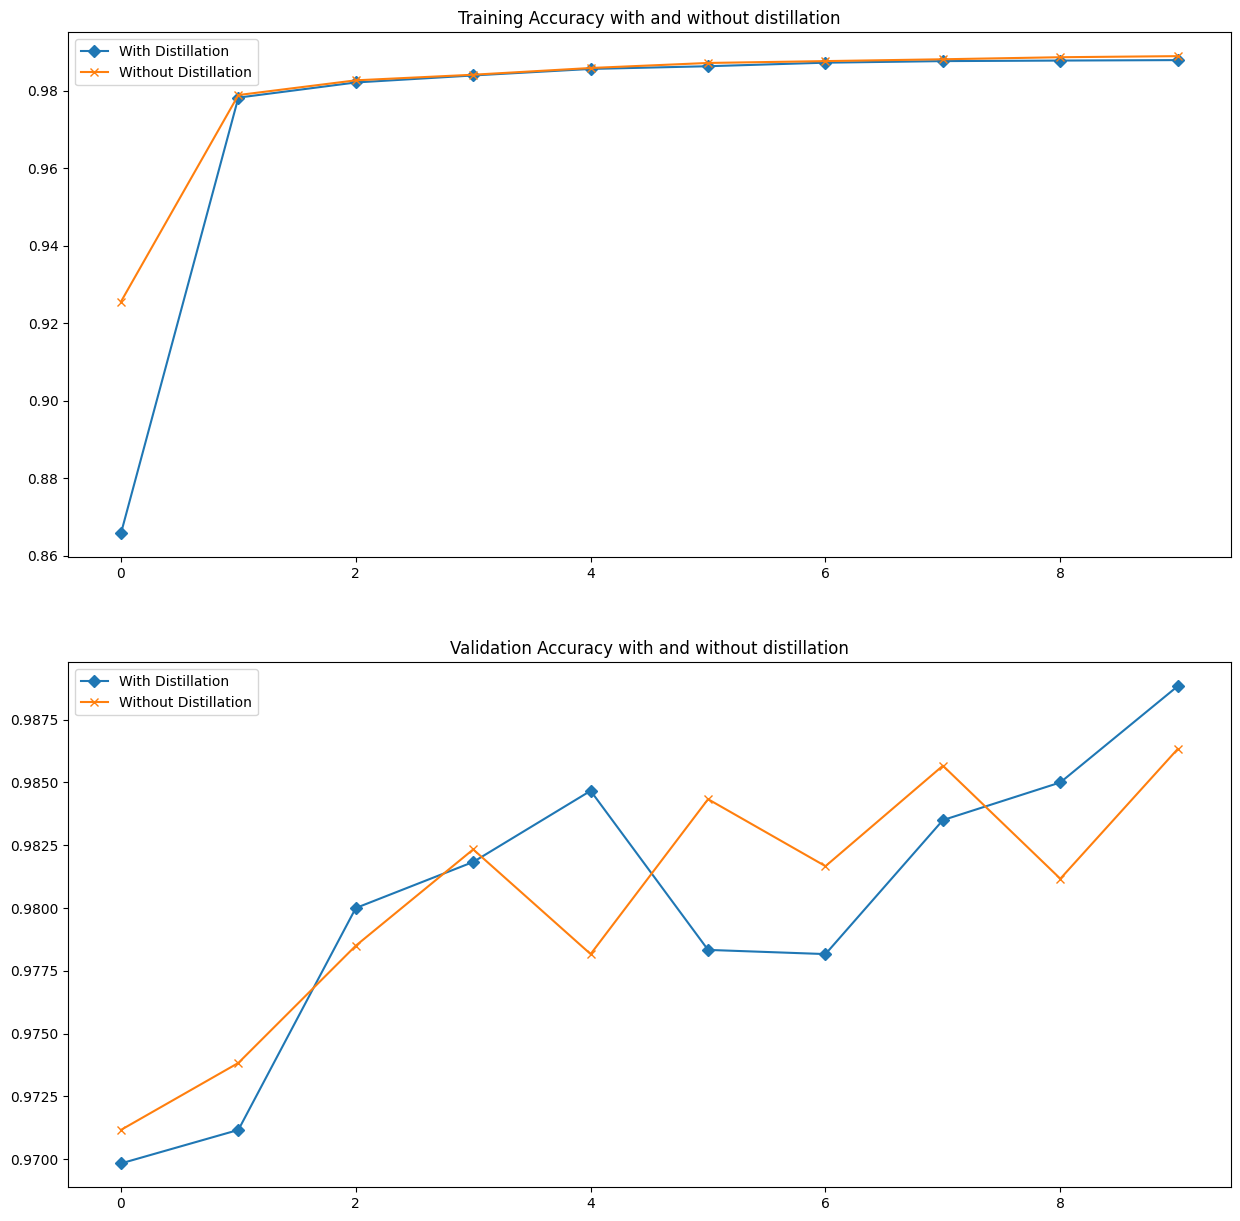

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

# Traning and validation results
axs[0].plot(np.mean(train_results_with_distillation, 1), '-D') 
axs[0].plot(np.mean(train_results_without_distillation, 1), '-x') 
axs[0].title.set_text('Training Accuracy with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Test results
axs[1].plot(val_results_with_distillation, '-D') 
axs[1].plot(val_results_without_distillation, '-x') 
axs[1].title.set_text('Validation Accuracy with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

In [10]:
print(f"Test accuracy with disstillation {test_results_with_distillation['sparse_categorical_accuracy']}")
print(f"Test accuracy without disstillation {test_results_without_distillation['sparse_categorical_accuracy']}")

Test accuracy with disstillation 0.9799000024795532
Test accuracy without disstillation 0.9757999777793884


In [11]:
# # Save the model to load in future
# %mkdir ExpModels/Exp3

# studnet_model.save('ExpModels/Exp3/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp3/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: ExpModels/Exp3/studnet_model\assets


INFO:tensorflow:Assets written to: ExpModels/Exp3/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp3/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp3/studnet_model_without_distillation\assets
